In [ ]:
import os
import zipfile
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Extract contents of archive
archive = zipfile.ZipFile("/content/drive/My Drive/Tsinghua truncated.zip", 'r')
archive.extractall()

Mounted at /content/drive/


In [ ]:
# Notebook config 
train_data_directory_imgs = '/content/Tsinghua truncated/low-resolution'
train_data_directory_annotations = '/content/Tsinghua truncated/Low-Annotations'
labels_directory = '/content/labels'
data_directory = '/content/data'
# num_imgs = 8343
# num_classes = 1393
img_width = 224
img_height = 224
channels = 3

In [ ]:
def img_path_to_tensor(path, img_width, img_height):
  if path.endswith('.jpg') or path.endswith('.jpeg'):
    # Load RGB image 
    img = Image.open(path).convert("RGB")
    source_width, source_height = img.size

    # Resize image to specified image dimensions
    img = img.resize((img_width, img_height),Image.ANTIALIAS)

    # Rescale the image
    img = np.array(img)/255

    # Convert tensor to 4D
    img = np.expand_dims(img, 0)

    # print(img.shape)
    # plt.imshow(img[0])
    # plt.show()

    return [img, source_width, source_height]

In [ ]:
def scaleBBoxParameter(target_img_dim, source_img_dim, parameter):
  scale_factor = target_img_dim / source_img_dim
  return parameter * scale_factor


def xml_to_bbox_parameters(path, target_width, target_height, source_width, source_height):
  if(path.endswith('.xml')):
    tree = ET.parse(path)
    root = tree.getroot()

    for hbbox in tree.findall('//headbndbox'):
      # xmin = scaleBBoxParameter(target_width, source_width, int(hbbox.find('xmin').text)) / target_width
      # ymin = scaleBBoxParameter(target_height, source_height, int(hbbox.find('ymin').text)) / target_height
      # xmax = scaleBBoxParameter(target_width, source_width, int(hbbox.find('xmax').text)) / target_width
      # ymax = scaleBBoxParameter(target_height, source_height, int(hbbox.find('ymax').text)) / target_height

      xmin = scaleBBoxParameter(target_width, source_width, int(hbbox.find('xmin').text))
      ymin = scaleBBoxParameter(target_height, source_height, int(hbbox.find('ymin').text))
      xmax = scaleBBoxParameter(target_width, source_width, int(hbbox.find('xmax').text))
      ymax = scaleBBoxParameter(target_height, source_height, int(hbbox.find('ymax').text))

      return (float(xmin), float(ymin), float(xmax), float(ymax))

In [ ]:
def drawBoundingBoxOnTensor(img_tensor, bbox_parameters):

  img_data = (img_tensor.squeeze()*255).astype(np.uint8)
  img = Image.fromarray(img_data, mode='RGB')

  img1 = ImageDraw.Draw(img)  
  img1.rectangle(bbox_parameters * 224, outline ="red")

  plt.imshow(img)
  plt.show()


In [ ]:
def convertToYoloV7AnnotationFormat(notYolo, source_width, source_height):
  xmin, ymin, xmax, ymax = notYolo
  width = (xmax - xmin)
  height = (ymax - ymin)
  x_center = (width / 2) + xmin
  y_center = (height / 2) + ymin
  return " ".join(str(i) for i in [x_center / source_width, y_center / source_height, width / source_width, height / source_height])

def writeYoloV7Label(img_width, img_height, annotation_path):
  annotation = xml_to_bbox_parameters(annotation_path, img_width, img_height, img_width, img_height)
  label = "0 " + convertToYoloV7AnnotationFormat(annotation, img_width, img_height)
  return label


In [ ]:
def loadDataset(img_folder_path, annotation_folder_path, img_width, img_height, class_limit):
  imgs = []
  annotations = []
  
  for subdir, dirs, files in tqdm(os.walk(img_folder_path)):
    data_class = subdir.split('/')[-1]
    class_count = 0
    for file in files:
      if(file.endswith('.jpg') or file.endswith('.jpeg')):

        img_path = img_folder_path + os.sep + data_class + os.sep + file
        annotation_path = annotation_folder_path + os.sep + data_class + os.sep + file + '.xml'
        yolo_label_path = labels_directory + os.sep + file.split('.')[0] + '.txt'
        yolo_data_path = data_directory + os.sep + file

        img_tensor_data = img_path_to_tensor(img_path, img_width, img_height)
        annotation = xml_to_bbox_parameters(annotation_path, img_width, img_height, img_tensor_data[1], img_tensor_data[2])

        # imgs.append(img_tensor_data[0])
        # annotations.append(annotation)

        # shutil.copy(img_path, yolo_data_path)

        with open(yolo_label_path, 'w') as writefile:
          writefile.write(writeYoloV7Label(img_tensor_data[1], img_tensor_data[2], annotation_path))

        # drawBoundingBoxOnTensor(img_tensor_data[0], annotation)
        class_count += 1

      # print(img_path)
      # print(annotation_path)

  return imgs, annotations

imgs, annotations = loadDataset(train_data_directory_imgs, train_data_directory_annotations, img_width, img_height, 200)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/headbndbox'
  # This is added back by InteractiveShellApp.init_path()
131it [03:23,  1.56s/it]


In [ ]:
imgs_array = np.concatenate(imgs)
annotations_array = np.array(annotations, dtype="float32")

print(imgs_array.shape, annotations_array.shape)
print(annotations_array[0])

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(imgs_array, annotations_array,
                                                    stratify=None, 
                                                    test_size=0.20, shuffle=True)

(2585, 224, 224, 3) (2585, 4)
[0.37       0.07407407 0.636      0.47089946]


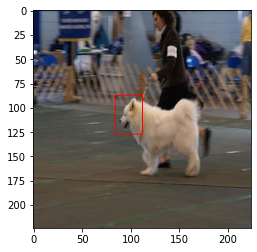

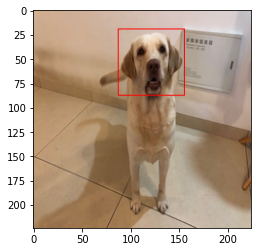

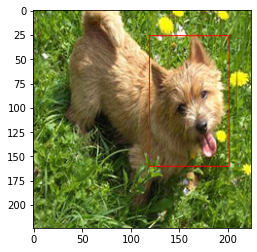

(517, 224, 224, 3)


In [ ]:
drawBoundingBoxOnTensor(X_train[8], Y_train[8])
drawBoundingBoxOnTensor(X_train[12], Y_train[12])
drawBoundingBoxOnTensor(X_test[10], Y_test[10])

print(X_test.shape)

In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import applications
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.inception_v3 import preprocess_input
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.optimizers import RMSprop, Adam

# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D,BatchNormalization,GlobalAveragePooling2D
# from keras.layers import Input, Lambda

# from keras.losses import SparseCategoricalCrossentropy, MSE

In [ ]:
# base_model = InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')

# flatten = base_model.output
# flatten = Flatten()(flatten)


# #create the classifier branch
# classifier_branch = Dense(128, activation='relu', name='cl_1')(flatten)
# classifier_branch = Dense(2, name='cl_head')(classifier_branch)  


# # construct a fully-connected layer header to output the predicted
# # bounding box coordinates
# locator_branch = Dense(128, activation="relu")(flatten)
# locator_branch = Dense(64, activation="relu")(locator_branch)
# locator_branch = Dense(32, activation="relu")(locator_branch)
# locator_branch = Dense(4, activation="sigmoid", name='lb_head')(locator_branch)


# model = Model(base_model.input,outputs=[locator_branch])


# losses = {
#    "lb_head":MSE}

# model.compile(loss=MSE, optimizer=Adam(0.0001), metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# history = model.fit(X_train, Y_train,
#              validation_data=(X_test, Y_test),
#              batch_size=32,
#              epochs=10,
#              verbose=1)

Epoch 1/10
65/65 [==============================] - 15s 108ms/step - loss: 0.0194 - accuracy: 0.7423 - val_loss: 0.0085 - val_accuracy: 0.8569
Epoch 2/10
65/65 [==============================] - 4s 67ms/step - loss: 0.0048 - accuracy: 0.8661 - val_loss: 0.0051 - val_accuracy: 0.8569
Epoch 3/10
65/65 [==============================] - 4s 68ms/step - loss: 0.0029 - accuracy: 0.9047 - val_loss: 0.0054 - val_accuracy: 0.8395
Epoch 4/10
65/65 [==============================] - 4s 67ms/step - loss: 0.0021 - accuracy: 0.9149 - val_loss: 0.0040 - val_accuracy: 0.8878
Epoch 5/10
65/65 [==============================] - 4s 67ms/step - loss: 0.0018 - accuracy: 0.9250 - val_loss: 0.0038 - val_accuracy: 0.8936
Epoch 6/10
65/65 [==============================] - 4s 67ms/step - loss: 0.0017 - accuracy: 0.9323 - val_loss: 0.0037 - val_accuracy: 0.9014
Epoch 7/10
65/65 [==============================] - 4s 68ms/step - loss: 0.0014 - accuracy: 0.9362 - val_loss: 0.0033 - val_accuracy: 0.8917
Epoch 8/10


In [ ]:
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7 # Downloading YOLOv7 repository and installing requirements
%cd yolov7
!pip3 install -qr requirements.txt


Cloning into 'yolov7'...
remote: Enumerating objects: 998, done.
remote: Total 998 (delta 0), reused 0 (delta 0), pack-reused 998
Receiving objects: 100% (998/998), 69.77 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (467/467), done.
/content/yolov7
     |████████████████████████████████| 1.6 MB 35.7 MB/s 


In [ ]:
# !zip -r Tsinghua_truncated_yoloV7_data.zip '/content/data'
!zip -r Tsinghua_truncated_yoloV7_labels.zip '/content/labels'
  

Streaming output truncated to the last 5000 lines.
  adding: content/labels/n120110.txt (deflated 13%)
  adding: content/labels/n111934.txt (deflated 8%)
  adding: content/labels/n127094.txt (deflated 37%)
  adding: content/labels/n129042.txt (deflated 20%)
  adding: content/labels/n114864.txt (deflated 16%)
  adding: content/labels/n112656.txt (deflated 44%)
  adding: content/labels/n118906.txt (deflated 43%)
  adding: content/labels/n126166.txt (deflated 14%)
  adding: content/labels/n117007.txt (deflated 33%)
  adding: content/labels/n128492.txt (deflated 20%)
  adding: content/labels/n101835.txt (deflated 27%)
  adding: content/labels/n128072.txt (deflated 12%)
  adding: content/labels/n133319.txt (deflated 8%)
  adding: content/labels/n115915.txt (deflated 60%)
  adding: content/labels/n112662.txt (deflated 26%)
  adding: content/labels/n154445.txt (deflated 33%)
  adding: content/labels/n131961.txt (deflated 48%)
  adding: content/labels/n133057.txt (deflated 53%)
  adding: conte